# Classification of ag plastics across California

Sentinel-2 classification of agricultural plastic use in California based on Harvard students' capstone project and Yuanyuan's internship project

Notebook authored by Annie Taylor, July 2024

Some key changes from previous analyses:
* Using validated training datasets
* Using different cloud-masking algorithm

### Set up ee api

In [1]:
import ee
import geemap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from datetime import datetime, timedelta
from sklearn.metrics import ConfusionMatrixDisplay
import geopandas

In [2]:
# ee.Authenticate(auth_mode='localhost')
ee.Initialize(project='ee-annalisertaylor')

### Load data

In [3]:
assets = 'projects/ee-annalisertaylor/assets/TNC/agplastics/'

# Yuanyuan's data
oxnard_bnd = ee.FeatureCollection(assets + 'Oxnard')
label_mulch_hoop = ee.FeatureCollection(assets + 'label_mulch_hoop')
label_nonplastic = ee.FeatureCollection(assets + 'label_nonplastic')
polygons = label_mulch_hoop.merge(label_nonplastic)
aoi_truck_crop = ee.FeatureCollection(assets + 'T')
# strawberries = ee.FeatureCollection(assets + 'Strawberries')
# bushberries = ee.FeatureCollection(assets + 'Bushberries_T19')
# flowers = ee.FeatureCollection(assets + 'Flowers_T16')
# peppers = ee.FeatureCollection(assets + 'Peppers_T21')
# avocados = ee.FeatureCollection(assets + 'Avocados')

# Load data from counties
fc_SantaMaria = ee.FeatureCollection(assets + 'SantaMaria_val')
fc_Mendocino = ee.FeatureCollection(assets + 'Mendocino_val')
fc_Watsonville = ee.FeatureCollection(assets + 'Watsonville_val')
fc_Oxnard = ee.FeatureCollection(assets + 'Oxnard_val')
# filter out a date from that fc with no images, only 29 points
fc_Oxnard = fc_Oxnard.filter(ee.Filter.neq('Date', '11/19/2018'))

# TODO could change the script to use csvs in repo
# train_path = "data/Validated_Training_Data/"
# santamaria = pd.read_csv(train_path + 'SantaMaria_val.csv')
# mendocino = pd.read_csv(train_path + 'Mendocino_val.csv')
# watsonville = pd.read_csv(train_path + 'Watsonville_val.csv')
# oxnard_pts = pd.read_csv(train_path + 'YYT_labeled_points.csv')
# oxnard_pts = geopandas.read_file('N:/OCEANS_Program/projects/Plastics/Agricultural_Plastics/Validated Training Data/YYT_RElabeled_points.shp')

# Encode labels
class_mapping = {'hoop': 0, 'mulch': 1, 'other': 2, 'greenhouse': 3}
# only watsonville has greenhouse points right now, santa maria has a separate (unimported) dataset

# California boundary
ca = ee.FeatureCollection("TIGER/2018/States").filter(ee.Filter.equals('NAME', 'California'))

## 1. Process Sentinel-2 Imagery

### Cloud mask Sentinel-2 images

In [4]:
startDate = ee.Date.fromYMD(2010, 1, 1) # setting these to be inclusive for now, can change
endDate = ee.Date.fromYMD(2025, 10, 1)

s2 = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
    .filter(ee.Filter.date(startDate, endDate)) \
    .filter(ee.Filter.bounds(ca)) \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 92))

# cloud mask using the cloudless image collection, pulling from EE documentation example
s2cloud = ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY')
s2cloud = s2cloud.filterBounds(ca)
MAX_CLOUD_PROBABILITY = 15

def maskClouds(img):
    clouds = ee.Image(img.get('cloud_mask')).select('probability')
    isNotCloud = clouds.lt(MAX_CLOUD_PROBABILITY)
    return img.updateMask(isNotCloud)

# Masks for the 10m bands can include bad data at scene edge; apply masks from the 20m and 60m bands too
def maskEdges(s2_img):
    return s2_img.updateMask(s2_img.select('B8A').mask().updateMask(s2_img.select('B9').mask()))

# Filter s2cloud to same region, fix 10m pixels at edges
s2_mask = s2.map(maskEdges)

# Join S2 with cloud probability dataset to add cloud mask
s2sr_cloudmask = ee.Join.saveFirst('cloud_mask').apply(primary=s2_mask, secondary=s2cloud, \
                            condition=ee.Filter.equals(leftField='system:index', rightField='system:index'))

s2_cldmsk = ee.ImageCollection(s2sr_cloudmask).map(maskClouds)

### Add VIs

In [5]:
def addNBR_RS(image):
    # reduces the resolution of the NIR band (10m) to match the SWIR band (20m)
    #   using the mean of all pixels within the larger pixel
    swir = image.select('B12')
    swir_projection = swir.projection()
    nir = image.select('B8').reduceResolution(reducer=ee.Reducer.mean(), maxPixels=16).reproject(crs=swir_projection)
    js_math_exp = 'c = (a-b) / (a+b)'
    js_math_img = ee.Image().expression(
        expression=js_math_exp, opt_map={'a': nir, 'b': swir}
    ).rename('NBR_RS')
    image = image.addBands(js_math_img)
    return image

def addVIs(image):
    image = image.addBands(image.normalizedDifference(['B8', 'B4']).rename('NDVI'))
    # image = image.addBands(image.normalizedDifference(['B8', 'B12']).rename('NBR')) # one band at 20m
    # image = image.addBands(image.normalizedDifference(['B8', 'B11']).rename('NDMI')) # one band at 20m
    # image = image.addBands(image.normalizedDifference(['B3', 'B8']).rename('NDWI'))
    # image = image.addBands(image.expression("2.5 * ((b('B8') - b('B4')) / (b('B8') + 6 * b('B4') - 7.5 * b('B2') + 1))").rename('EVI'))
    image = image.addBands(image.normalizedDifference(['B11', 'B12']).rename('NDTI')) # swir1 and swir2, both 20m
    image = image.addBands(image.expression("(100 * b('B2') * (b('B8') - b('B4')))/(1 - ((b('B2') + b('B3') + b('B8')) / 3))").rename('PGI'))
    image = image.addBands(image.expression("b('B2')/(1 - ((b('B2') + b('B3') + b('B8')) / 3))").rename('RPGI'))
    image = image.addBands(image.normalizedDifference(['B11', 'B4']).rename('PMLI')) # one band at 20m
    image = image.addBands(image.normalizedDifference(['B11', 'B8']).rename('NDBI')) # one band at 20m    
    return image

# def adjPGI(image):
    # make PGI = 0 where NDVI is higher than __ and NDBI is lower than ___. 
    # add it to image as PGI_adj



### Build the collection

In [6]:
processedCollection = s2_cldmsk.map(addVIs)
# print(processedCollection.size().getInfo())
print(processedCollection.first().bandNames().getInfo())

['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'AOT', 'WVP', 'SCL', 'TCI_R', 'TCI_G', 'TCI_B', 'MSK_CLDPRB', 'MSK_SNWPRB', 'QA10', 'QA20', 'QA60', 'NDVI', 'NDTI', 'PGI', 'RPGI', 'PMLI', 'NDBI']


In [7]:
# start = '2023-04-26'
# end = '2023-05-16'
# images = processedCollection.filterBounds(oxnard_bnd).filterDate(start, end)
# print(images.size().getInfo())

# m = geemap.Map()
# m.addLayer(oxnard_bnd)
# m.addLayer(images)
# m.centerObject(oxnard_bnd)
# m

# recent = images.sort('system:index', False).limit(10)
# recent

In [8]:
# Select bands to use to train the model
bands = [
    'B4', 'B3', 'B2', 'B6', 'B8', 'B11', 'B12',
    'NDVI', 'NDTI', 'PGI', 'RPGI', 'PMLI'
]

### Functions to sample image mosaics for certain dates and places

In [37]:
def get_collection_on_date(df, county, date, roi):
    # Filter for date
    df_date = df[df["Date"]==date]

    # Get coordinates as a list
    points = []
    for idx, row in df_date.iterrows():
        point = ee.Geometry.Point([row['Longitude'], row['Latitude']])
        feature = ee.Feature(point, {'class': row['NumericType']})
        points.append(feature)
    
    fc = ee.FeatureCollection(points)
    # Get image for a month's range
    date_ = datetime.strptime(date, "%Y-%m-%d")
    start = (date_ - timedelta(days=10)).strftime("%Y-%m-%d")
    end = (date_ + timedelta(days=10)).strftime("%Y-%m-%d")

    trimmedCollection = processedCollection.filterDate(start, end).filterBounds(roi)
    image = trimmedCollection.median()# I don't think you need to.clip(roi)
    # roi = minimum bounds from training points lat/lon
    
    # Sample points from image
    data = image.select(bands).sampleRegions(
        collection=fc,
        properties=['class'],
        scale=10,
        geometries=True
    )
    # Add 'date' as a property to each feature in the feature collection
    data = data.map(lambda feature: feature.set('date', date))
    print(f"Total number of labeled data for {date} in {county}:", data.size().getInfo())
    # returns a fc
    return data

In [38]:
# already defined above
# class_mapping = {'hoop': 0, 'mulch': 1, 'other': 2, 'greenhouse': 3}

def processCountyFeatureCollection(fc, county):
    # Make dataframe 
    # TODO use geemap fc to df function
    dict_list = [feat['properties'] for feat in fc.getInfo()['features']]
    df = pd.DataFrame(dict_list)
    # Encode labels
    df['NumericType'] = df['Type'].map(class_mapping)
    # Drop greenhouse type (for now)
    df = df[df["Type"]!="greenhouse"]
    # Format dates to YYYY-MM-DD
    df['Date'] = pd.to_datetime(df['Date']).dt.strftime('%Y-%m-%d')
    # Filter for dates when Sentinel-2 is available
    df = df[df['Date'] > '2018-05-09']
    
    # County boundaries based off csv coordinates
    min_lon = df['Longitude'].min()
    max_lon = df['Longitude'].max()
    min_lat = df['Latitude'].min()
    max_lat = df['Latitude'].max()
    roi = ee.Geometry.Rectangle([min_lon, min_lat, max_lon, max_lat])
    
    # Iterate through unique dates
    # df = df[df.groupby('Date')['Date'].transform('size') > 100]
    # dateslist = df["Date"].value_counts()
    dates = df["Date"].unique()
    all_county_data = []
    
    for date in dates:
        all_county_data.append(get_collection_on_date(df, county, date, roi))
    # all_county_data is a list of feature collections, same number as dates for that county
    county_fc = ee.FeatureCollection(all_county_data).flatten()
    # add the county name as a property to each feature
    def addCountyProperty(feature):
        return feature.set('county', county)
    county_fc = county_fc.map(addCountyProperty)
    print(f"Total number of labeled data in {county}:", county_fc.size().getInfo())
    return county_fc

## 2. Sample each feature collection to build training dataset

In [39]:
data_Mendocino = processCountyFeatureCollection(fc_Mendocino, "Mendocino")

# df_mendo = geemap.ee_to_gdf(data_Mendocino)
# display(df_mendo)
# data_Mendocino.limit(5)

Total number of labeled data for 2021-06-02 in Mendocino: 262
Total number of labeled data in Mendocino: 262


In [40]:
data_SantaMaria = processCountyFeatureCollection(fc_SantaMaria, "Santa Maria")

Total number of labeled data for 2022-08-26 in Santa Maria: 69
Total number of labeled data for 2023-05-05 in Santa Maria: 166
Total number of labeled data for 2022-03-10 in Santa Maria: 242
Total number of labeled data for 2021-02-06 in Santa Maria: 119
Total number of labeled data in Santa Maria: 596


In [41]:
data_Watsonville = processCountyFeatureCollection(fc_Watsonville, "Watsonville")

Total number of labeled data for 2020-09-26 in Watsonville: 272
Total number of labeled data for 2021-09-27 in Watsonville: 388
Total number of labeled data for 2022-09-11 in Watsonville: 347
Total number of labeled data for 2023-04-12 in Watsonville: 369
Total number of labeled data in Watsonville: 1376


In [42]:
data_Oxnard = processCountyFeatureCollection(fc_Oxnard, "Oxnard")

Total number of labeled data for 2019-10-14 in Oxnard: 23
Total number of labeled data for 2023-05-06 in Oxnard: 496
Total number of labeled data for 2023-11-09 in Oxnard: 174
Total number of labeled data for 2019-05-17 in Oxnard: 116
Total number of labeled data for 2022-09-21 in Oxnard: 7
Total number of labeled data for 2019-08-19 in Oxnard: 15
Total number of labeled data for 2020-02-15 in Oxnard: 40
Total number of labeled data for 2021-07-13 in Oxnard: 80
Total number of labeled data for 2022-06-13 in Oxnard: 151
Total number of labeled data for 2023-05-07 in Oxnard: 32
Total number of labeled data for 2023-05-11 in Oxnard: 17
Total number of labeled data for 2023-10-17 in Oxnard: 121
Total number of labeled data for 2022-11-01 in Oxnard: 67
Total number of labeled data for 2019-04-01 in Oxnard: 14
Total number of labeled data for 2022-10-01 in Oxnard: 64
Total number of labeled data in Oxnard: 1417


##### Debugging oxnard data

In [43]:
# # Make dataframe
# dict_list = [feat['properties'] for feat in fc_Oxnard.getInfo()['features']]
# df = pd.DataFrame(dict_list)
# # Encode labels
# df['NumericType'] = df['Type'].map(class_mapping)
# # Drop greenhouse type (for now)
# df = df[df["Type"]!="greenhouse"]
# # Format dates to YYYY-MM-DD
# df['Date'] = pd.to_datetime(df['Date']).dt.strftime('%Y-%m-%d')
# # Filter for dates when Sentinel-2 is available
# df = df[df['Date'] > '2018-05-09']

# # County boundaries based off csv coordinates
# min_lon = df['Longitude'].min()
# max_lon = df['Longitude'].max()
# min_lat = df['Latitude'].min()
# max_lat = df['Latitude'].max()
# roi = ee.Geometry.Rectangle([min_lon, min_lat, max_lon, max_lat])

# # start = '2023-04-26'
# # end = '2023-05-16'
# # images = processedCollection.filterDate(start, end).filterBounds(roi)
# # print(images.size().getInfo())
# dateslist = df["Date"].value_counts()

# date = '2018-11-19'
# dates = df["Date"].unique()
# display(dates)
# display(dateslist)

# # Filter for date
# df_date = df[df["Date"]==date]

# # Get coordinates as a list
# points = []
# for idx, row in df_date.iterrows():
#     point = ee.Geometry.Point([row['Longitude'], row['Latitude']])
#     feature = ee.Feature(point, {'class': row['NumericType']})
#     points.append(feature)

# fc = ee.FeatureCollection(points)
# # Get image for a month's range
# date_ = datetime.strptime(date, "%Y-%m-%d")
# start = (date_ - timedelta(days=10)).strftime("%Y-%m-%d")
# end = (date_ + timedelta(days=10)).strftime("%Y-%m-%d")

# trimmedCollection = processedCollection.filterDate(start, end).filterBounds(roi)
# image = trimmedCollection.median()# I don't think you need to.clip(roi)
# # roi = minimum bounds from training points lat/lon

# # Sample points from image
# data = image.select(bands).sampleRegions(
#     collection=fc,
#     properties=['class'],
#     scale=10,
#     geometries=True
# )

# # display(data)
# print(data.size().getInfo())
# # m = geemap.Map()
# # m.addLayer(image)
# # m.addLayer(roi)
# # m.centerObject(roi)
# # m

##### Load data for Oxnard - old
changing this to 2023 because Yuanyuan used mostly gee basemap imagery during summer of 2023

In [44]:
# START = '2023-02-01'
# END = '2023-06-01'

# trimmedCollection = processedCollection.filterDate(START, END).filterBounds(oxnard_bnd)
# image = trimmedCollection.median()

# # stratified sample of the oxnard_pts to avoid memory limit cap
# oxnard_pts['class'] = oxnard_pts['CID']
# # oxnard_pts = oxnard_pts.reset_index()
# # oxnard_pts = oxnard_pts.groupby('class').apply(lambda x: x.sample(frac=0.8))
# oxnard = geemap.geopandas_to_ee(oxnard_pts).limit(800)

# data_Oxnard = image.sampleRegions(
#     collection=oxnard,
#     properties=['class'],
#     scale=10,
#     geometries=False
# )
# print(f"Total number of labeled data in Oxnard:", data_Oxnard.size().getInfo())

# # batching it example from other work
# # diff version with chunk_cover as the region
# def RR_all_features(img):
#     fc_means = ee.FeatureCollection(img.reduceRegions(chunk_cover, ee.Reducer.mean(), 10))
#     img_date = img.date().format("MM-dd-YYYY")
#     img_wy = img.get('system:index')
#     def set_date(feat):
#         return feat.set({'Date': img_date, 'WaterYear': img_wy})
#     fc_means = ee.FeatureCollection(fc_means.map(set_date))
#     return fc_means

# # Separate the points into chunks of 1000, run reduceRegions to get stats, and then recombine into one df
# chunks = [0, 1000, 2000]
# add_dfs = []

# for i in range(len(chunks)-1):
#     chunk_cover = sub_cover.iloc[chunks[i]:chunks[i+1]] # sub-sample the full df 
#     chunk_cover = geemap.geopandas_to_ee(chunk_cover) # convert to ee fc
#     result = ee.FeatureCollection(annualMetricsSelected.map(RR_all_features)).flatten()
#     chunk_df = geemap.ee_to_df(result)
#     add_dfs.append(chunk_df)
    
# recombined_dfs = pd.concat(add_dfs, ignore_index=True)

#### Combine sampled training data

In [45]:
# Combine all data
all_data = []
all_data.append(data_SantaMaria)
all_data.append(data_Mendocino)
all_data.append(data_Watsonville)
all_data.append(data_Oxnard)

data = ee.FeatureCollection(all_data).flatten().randomColumn(seed=0)
# df = geemap.ee_to_df(data) # useful for stats calculations/visualization

In [49]:
# df.sample(20)

In [28]:
# # add a random column to split into train/validation
# # data = ee.FeatureCollection(all_data).flatten().randomColumn(seed=0)
# # save the fc as an asset to see if this speeds up analysis
# asset_id = 'projects/ee-annalisertaylor/assets/TNC/agplastics/labeled_point_data'

# task = ee.batch.Export.table.toAsset(
#     collection=data,
#     description='Export training data to asset',
#     assetId=asset_id
# )
# task.start()

In [20]:
# import that fc back
# data = ee.FeatureCollection(asset_id)

## 3. Split training and validation data

In [48]:
# Process data (1): Train test split
# print(f"Total number of labeled data:", data.size().getInfo())
split = 0.7
training = data.filter(ee.Filter.lt('random', split))
validation = data.filter(ee.Filter.gte('random', split))
# print(f"Number of training points: {training.size().getInfo()}")
# print(f"Number of validation points: {validation.size().getInfo()}")

Number of training points: 2583
Number of validation points: 1068


#### Training data stats

In [50]:
# convert to dfs for easier stats
training_df = geemap.ee_to_df(training)
validation_df = geemap.ee_to_df(validation)

print(f"Number of training points: {training_df.shape[0]}")
print(f"Number of validation points: {validation_df.shape[0]}")

# Check number of data in each county
# print("Number of training points:", training_df['county'].value_counts())
# print("Number of validation points:", validation_df['county'].value_counts())

county
Oxnard         1023
Watsonville     974
Santa Maria     409
Mendocino       177
Name: count, dtype: int64
county
Watsonville    402
Oxnard         394
Santa Maria    187
Mendocino       85
Name: count, dtype: int64


#### Address spatial autocorrelation
- Remove points within 30 min of each other between the training and validation datasets
- DOES NOT ADDRESS SPATIAL AUTOCORRELATION W/IN THESE DATASETS and also the fact that many of these points are from different dates :/ 

In [51]:
# Process data (2): Address autocorrelation correction
# TODO how are we addressing spatial autocorrelation within each dataset?
# right now this is simply removing any training data points within 30m of a validation point
distFilter = ee.Filter.withinDistance(
    distance=30,
    leftField='.geo',
    rightField='.geo',
    maxError=10
)
join = ee.Join.inverted()
training = join.apply(training, validation, distFilter)
# print(f"Number of training points after removing autocorrelation: {training.size().getInfo()}")

In [52]:
# convert to dfs for easier stats again
training_df = geemap.ee_to_df(training)
# Check number of training data in each region again
display("Number of training points:", training_df['county'].value_counts())

'Number of training points:'

county
Oxnard         890
Watsonville    710
Santa Maria    396
Mendocino       83
Name: count, dtype: int64

In [55]:
# print("Number of training points of each class:", training_df['class'].value_counts())
for class_name, class_id in class_mapping.items():
   filtered_df = df[df['class'] == class_id]
   print(f"Number of points labeled {class_name}: {filtered_df.shape[0]}")

Number of points labeled hoop: 496
Number of points labeled mulch: 1029
Number of points labeled other: 2126
Number of points labeled greenhouse: 0


## 4. Train and Evaluate Models

In [56]:
def train_model(classifier, training, bands):
  trained_classifier = classifier.train(training, 'class', bands)
  return trained_classifier, trained_classifier.confusionMatrix()

def evaluate_model(trained_classifier, validation):
  classifications = validation.classify(trained_classifier)
  return classifications, classifications.errorMatrix('class', 'classification')

In [58]:
# Train the models 
# Model 1: SVM
trained_SVM, trainAccuracy_SVM = train_model(ee.Classifier.libsvm(kernelType='RBF', gamma=0.5, cost=10), training, bands)
_, validationAccuracy_SVM = evaluate_model(trained_SVM, validation)

# Model 2: CART
trained_CART, trainAccuracy_CART = train_model(ee.Classifier.smileCart(), training, bands)
_, validationAccuracy_CART = evaluate_model(trained_CART, validation)

# Model 3: RF
trained_RF, trainAccuracy_RF = train_model(ee.Classifier.smileRandomForest(50), training, bands)
classifications_RF, validationAccuracy_RF = evaluate_model(trained_RF, validation)

# Model 4: GTB
trained_GTB, trainAccuracy_GTB = train_model(ee.Classifier.smileGradientTreeBoost(50), training, bands)
classifications_GTB, validationAccuracy_GTB = evaluate_model(trained_GTB, validation)


In [59]:
# Get their accuracies (train and validation)
# takes ~10 min
train_accuracies = [trainAccuracy_SVM.accuracy().getInfo(),
                   trainAccuracy_CART.accuracy().getInfo(),
                   trainAccuracy_RF.accuracy().getInfo(),
                   trainAccuracy_GTB.accuracy().getInfo()]
validation_accuracies = [validationAccuracy_SVM.accuracy().getInfo(),
                        validationAccuracy_CART.accuracy().getInfo(),
                        validationAccuracy_RF.accuracy().getInfo(),
                        validationAccuracy_GTB.accuracy().getInfo()]

In [62]:
# Report out
print(f"SVM model \n training accuracy {train_accuracies[0]} \n validation accuracy {validation_accuracies[0]}")
print(f"CART model \n training accuracy {train_accuracies[1]} \n validation accuracy {validation_accuracies[1]}")
print(f"RF model \n training accuracy {train_accuracies[2]} \n validation accuracy {validation_accuracies[2]}")
print(f"GDB model \n training accuracy {train_accuracies[3]} \n validation accuracy {validation_accuracies[3]}")

SVM model 
 training accuracy 1 
 validation accuracy 0.5795880149812734
CART model 
 training accuracy 1 
 validation accuracy 0.849250936329588
RF model 
 training accuracy 0.9961519961519961 
 validation accuracy 0.900749063670412
GDB model 
 training accuracy 0.9807599807599807 
 validation accuracy 0.8941947565543071


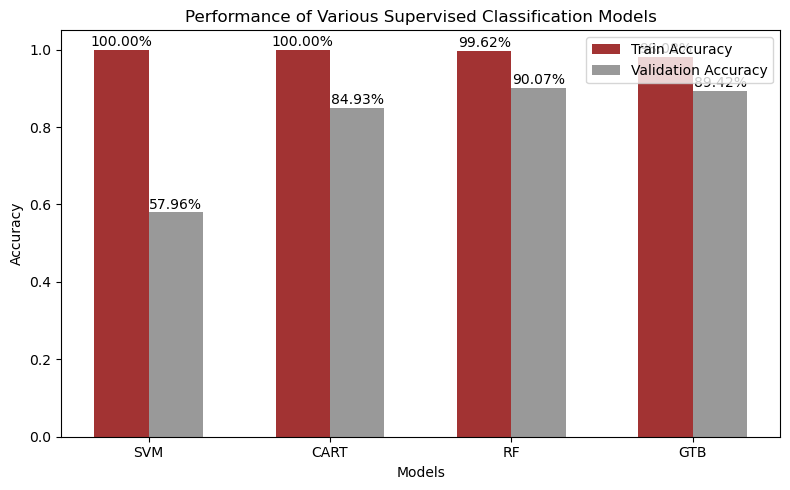

In [65]:
model_names = ["SVM", "CART", "RF", "GTB"]
# Define the width of each bar and the positions of the bars
bar_width = 0.3
index = np.arange(len(model_names))
train_color = 'darkred'
validation_color = 'grey'

# Plotting
plt.figure(figsize=(8, 5))
bars1 = plt.bar(index, train_accuracies, bar_width, label='Train Accuracy', color=train_color, alpha=0.8)
bars2 = plt.bar(index + bar_width, validation_accuracies, bar_width, label='Validation Accuracy', color=validation_color, alpha=0.8)

# Add percentage values on top of the bars
for bar1, bar2 in zip(bars1, bars2):
    plt.text(bar1.get_x() + bar1.get_width() / 2, bar1.get_height() + 0.01, f'{bar1.get_height():.2%}', ha='center', color='black', fontsize=10)
    plt.text(bar2.get_x() + bar2.get_width() / 2, bar2.get_height() + 0.01, f'{bar2.get_height():.2%}', ha='center', color='black', fontsize=10)

plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Performance of Various Supervised Classification Models')
plt.xticks(index + bar_width / 2, model_names)
plt.legend()
plt.tight_layout()
plt.show()

# Validation accuracies of CART, RF, and GTB are better here than in capstone notebook, SVM is worse

In [66]:
# Plot confusion matrix
display_labels = ["hoop", "mulch", "other"]

In [70]:
# Accuracy for Model 3: RF
# I believe this is all redundant with the above, but I'm leaving it in for now
# trained_RF, trainAccuracy_RF = train_model(ee.Classifier.smileRandomForest(50), training, bands)
# classifications_RF, validationAccuracy_RF = evaluate_model(trained_RF, validation)
# print("RF:")
# print(f"\tTraining accuracy:{trainAccuracy_RF.accuracy().getInfo()}")
# print(f"\tValidation accuracy:{validationAccuracy_RF.accuracy().getInfo()}")

Text(0.5, 1.0, 'RF Confusion Matrix (90.07% Accuracy)')

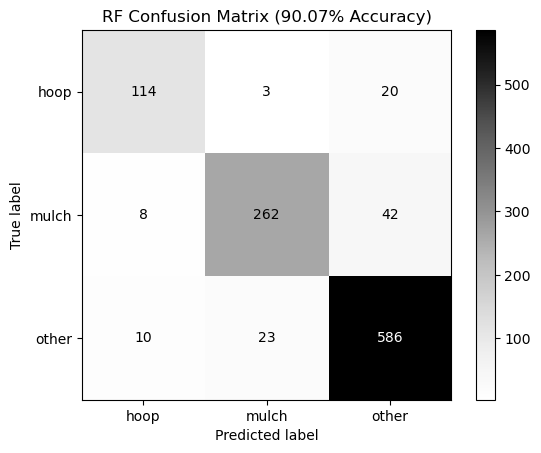

In [67]:
cm_RF = np.array(validationAccuracy_RF.getInfo())
disp = ConfusionMatrixDisplay(confusion_matrix=cm_RF,
                              display_labels=display_labels)
disp.plot(cmap=plt.cm.Greys)
disp.ax_.set_title(f"RF Confusion Matrix ({validationAccuracy_RF.accuracy().getInfo():.2%} Accuracy)")

In [68]:
def plot_each_county_cm(cm_Counties):
  f, axes = plt.subplots(1, 4, figsize=(20, 5), sharey='row')

  for i, (county, cm) in enumerate(cm_Counties.items()):
      disp = ConfusionMatrixDisplay(confusion_matrix=np.array(cm.getInfo()),
                                    display_labels=display_labels)
      disp.plot(ax=axes[i], cmap=plt.cm.Blues)
      disp.ax_.set_title(f"{county} ({cm.accuracy().getInfo():.2%} Accuracy)")
      disp.im_.colorbar.remove()
      disp.ax_.set_xlabel('')
      if i!=0:
          disp.ax_.set_ylabel('')

  f.text(0.4, 0.1, 'Predicted label', ha='left')
  plt.subplots_adjust(wspace=0.2, hspace=0.1)

  f.colorbar(disp.im_, ax=axes)
  plt.show()

In [71]:
# classifications_RF

In [72]:
filter_SantaMaria = ee.Filter.stringContains('county', 'Santa Maria')
filter_Mendocino = ee.Filter.stringStartsWith('county', 'Mendocino')
filter_Watsonville = ee.Filter.stringStartsWith('county', 'Watsonville')
filter_Oxnard = ee.Filter.stringStartsWith('county', 'Oxnard')

cm_SantaMaria = classifications_RF.filter(filter_SantaMaria).errorMatrix('class', 'classification')
cm_Mendocino = classifications_RF.filter(filter_Mendocino).errorMatrix('class', 'classification')
cm_Watsonville = classifications_RF.filter(filter_Watsonville).errorMatrix('class', 'classification')
cm_Oxnard = classifications_RF.filter(filter_Oxnard).errorMatrix('class', 'classification')
cm_Counties = {"Santa Maria": cm_SantaMaria, "Mendocino": cm_Mendocino, "Watsonville": cm_Watsonville, "Oxnard": cm_Oxnard}

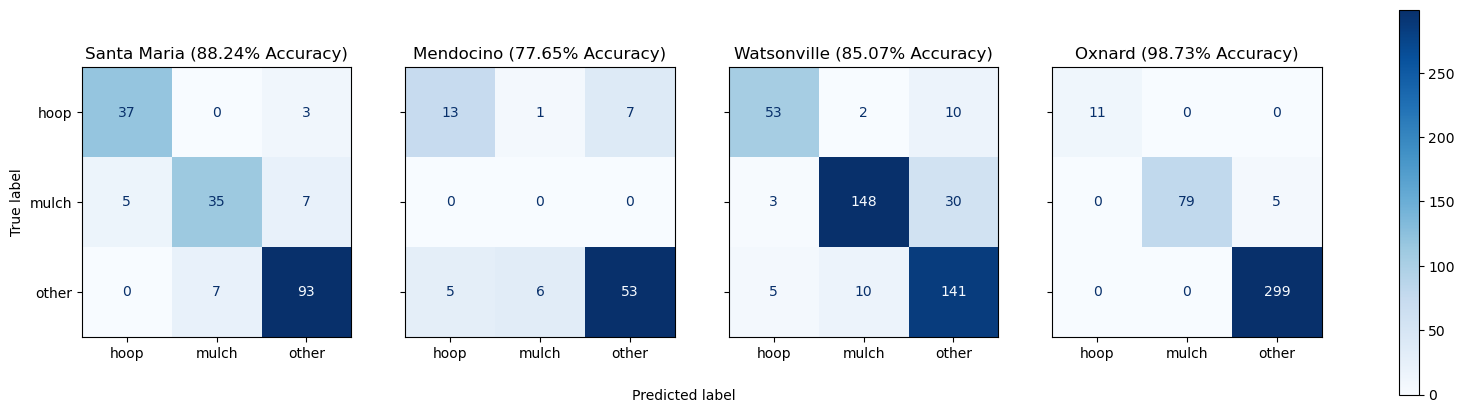

In [73]:
plot_each_county_cm(cm_Counties)

In [74]:
validationAccuracy_RF.fscore().getInfo()

[0.8475836431226766, 0.8733333333333333, 0.925019731649566]

# Data Augmentation

## Distance to coast

In [75]:
# RF with Data Augmentation (distance to coast)
trained_RF_coast, trainAccuracy_RF_coast = train_model(ee.Classifier.smileRandomForest(50), training, bands + ['distance_to_coast'])
classifications_RF_coast, validationAccuracy_RF_coast = evaluate_model(trained_RF_coast, validation)
print("RF with Data Augmentation (distance to coast):")
print(f"\tTraining accuracy:{trainAccuracy_RF_coast.accuracy().getInfo()}")
print(f"\tValidation accuracy:{validationAccuracy_RF_coast.accuracy().getInfo()}")

RF with Data Augmentation (distance to coast):


EEException: Property 'distance_to_coast' of feature '0_0_23_0' is missing.

Text(0.5, 1.0, 'RF Confusion Matrix with Data Augmentation (All 4 counties)')

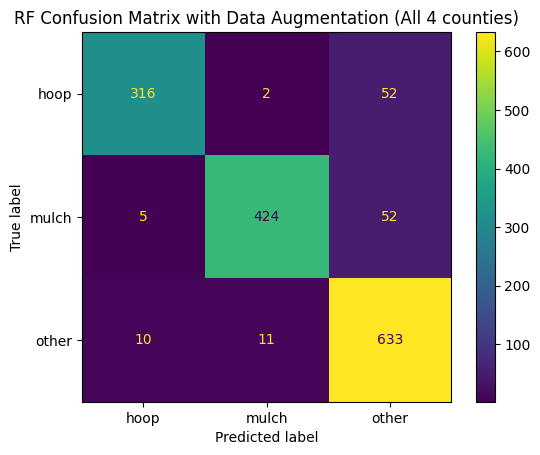

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=np.array(validationAccuracy_RF_coast.getInfo()), display_labels = ["hoop", "mulch", "other"])
disp.plot()
disp.ax_.set_title("RF Confusion Matrix with Data Augmentation (All 4 counties)")

In [ ]:
cm_SantaMaria_coast = classifications_RF_coast.filter(filter_SantaMaria).errorMatrix('class', 'classification')
cm_Mendocino_coast = classifications_RF_coast.filter(filter_Mendocino).errorMatrix('class', 'classification')
cm_Watsonville_coast = classifications_RF_coast.filter(filter_Watsonville).errorMatrix('class', 'classification')
cm_Oxnard_coast = classifications_RF_coast.filter(filter_Oxnard).errorMatrix('class', 'classification')
cm_Counties_coast = {"Santa Maria": cm_SantaMaria_coast, "Mendocino": cm_Mendocino_coast, "Watsonville": cm_Watsonville_coast, "Oxnard": cm_Oxnard_coast}

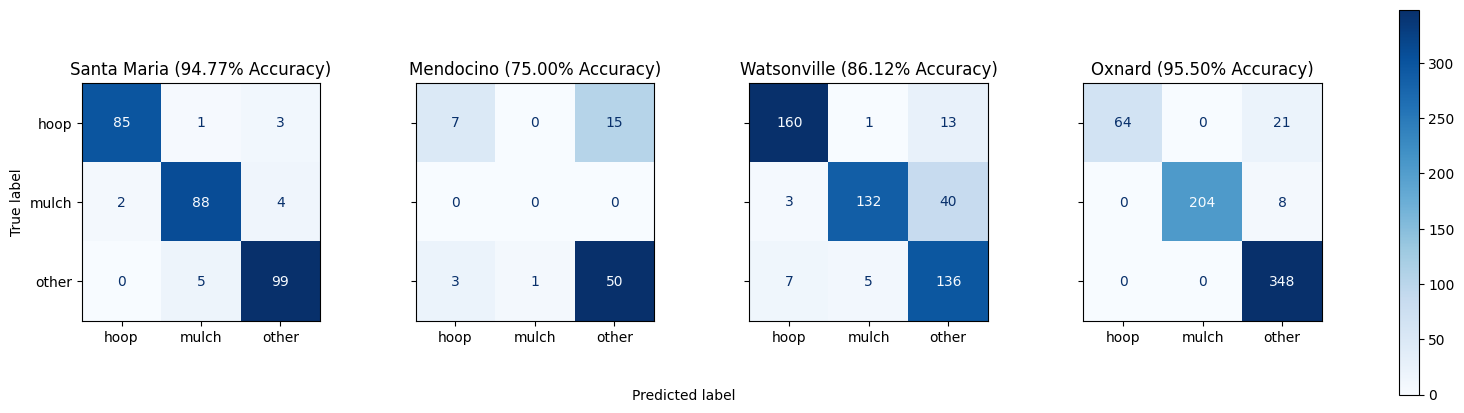

In [ ]:
plot_each_county_cm(cm_Counties_coast)

## Elevation

In [ ]:
# RF with Data Augmentation (elevation)
trained_RF_elevation, trainAccuracy_RF_elevation = train_model(ee.Classifier.smileRandomForest(50), training, bands + ['elevation'])
classifications_RF_elevation, validationAccuracy_RF_elevation = evaluate_model(trained_RF_elevation, validation)
print("RF with Data Augmentation (elevation):")
print(f"\tTraining accuracy:{trainAccuracy_RF_elevation.accuracy().getInfo()}")
print(f"\tValidation accuracy:{validationAccuracy_RF_elevation.accuracy().getInfo()}")

RF with Data Augmentation (elevation):
	Training accuracy:0.9965836993655441
	Validation accuracy:0.8950166112956811


In [ ]:
cm_SantaMaria_elevation = classifications_RF_elevation.filter(filter_SantaMaria).errorMatrix('class', 'classification')
cm_Mendocino_elevation = classifications_RF_elevation.filter(filter_Mendocino).errorMatrix('class', 'classification')
cm_Watsonville_elevation = classifications_RF_elevation.filter(filter_Watsonville).errorMatrix('class', 'classification')
cm_Oxnard_elevation = classifications_RF_elevation.filter(filter_Oxnard).errorMatrix('class', 'classification')
cm_Counties_elevation = {"Santa Maria": cm_SantaMaria_elevation, "Mendocino": cm_Mendocino_elevation, "Watsonville": cm_Watsonville_elevation, "Oxnard": cm_Oxnard_elevation}

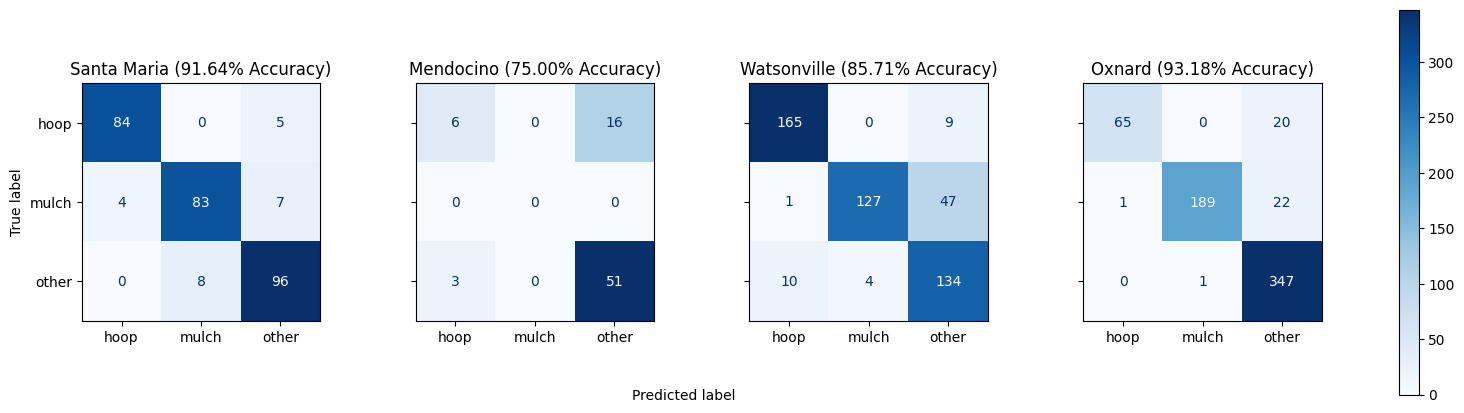

In [ ]:
plot_each_county_cm(cm_Counties_elevation)

## Distance to Coast + Elevation

In [ ]:
# RF with Data Augmentation (distance to coast + elevation)
trained_RF_all, trainAccuracy_RF_all = train_model(ee.Classifier.smileRandomForest(50), training, bands + ['distance_to_coast', 'elevation'])
classifications_RF_all, validationAccuracy_RF_all = evaluate_model(trained_RF_all, validation)
print("RF with Data Augmentation (distance to coast + elevation):")
print(f"\tTraining accuracy:{trainAccuracy_RF_all.accuracy().getInfo()}")
print(f"\tValidation accuracy:{validationAccuracy_RF_all.accuracy().getInfo()}")

RF with Data Augmentation (distance to coast + elevation):
	Training accuracy:0.9970717423133236
	Validation accuracy:0.9162790697674419


Text(0.5, 1.0, 'RF with Geographical Features\nConfusion Matrix (91.63% Accuracy)')

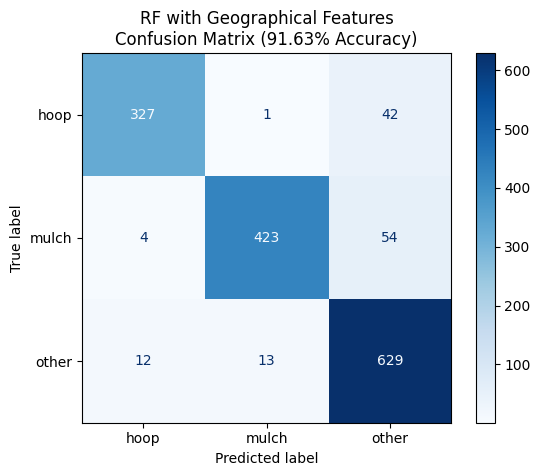

In [ ]:
cm_RF_all = np.array(validationAccuracy_RF_all.getInfo())
disp = ConfusionMatrixDisplay(confusion_matrix=cm_RF_all,
                              display_labels=display_labels)
disp.plot(cmap=plt.cm.Blues)
disp.ax_.set_title(f"RF with Geographical Features\nConfusion Matrix ({validationAccuracy_RF_all.accuracy().getInfo():.2%} Accuracy)")

In [ ]:
cm_SantaMaria_all = classifications_RF_all.filter(filter_SantaMaria).errorMatrix('class', 'classification')
cm_Mendocino_all = classifications_RF_all.filter(filter_Mendocino).errorMatrix('class', 'classification')
cm_Watsonville_all = classifications_RF_all.filter(filter_Watsonville).errorMatrix('class', 'classification')
cm_Oxnard_all = classifications_RF_all.filter(filter_Oxnard).errorMatrix('class', 'classification')
cm_Counties_all = {"Santa Maria": cm_SantaMaria_all, "Mendocino": cm_Mendocino_all, "Watsonville": cm_Watsonville_all, "Oxnard": cm_Oxnard_all}

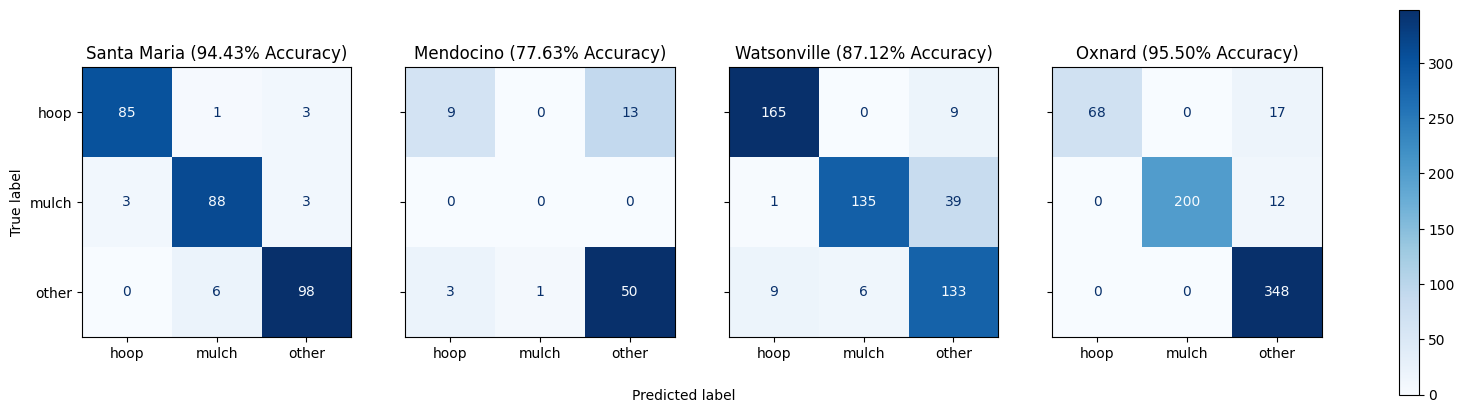

In [ ]:
plot_each_county_cm(cm_Counties_all)

In [ ]:
# Define the counties and their accuracy values (without and with augmentation)
counties = ["Santa Maria", "Mendocino", "Watsonville", "Oxnard"]
accuracy_before_augmentation = [cm_SantaMaria.accuracy().getInfo(),
                              cm_Mendocino.accuracy().getInfo(),
                              cm_Watsonville.accuracy().getInfo(),
                              cm_Oxnard.accuracy().getInfo(),]
accuracy_after_augmentation = [cm_SantaMaria_all.accuracy().getInfo(),
                              cm_Mendocino_all.accuracy().getInfo(),
                              cm_Watsonville_all.accuracy().getInfo(),
                              cm_Oxnard_all.accuracy().getInfo(),]

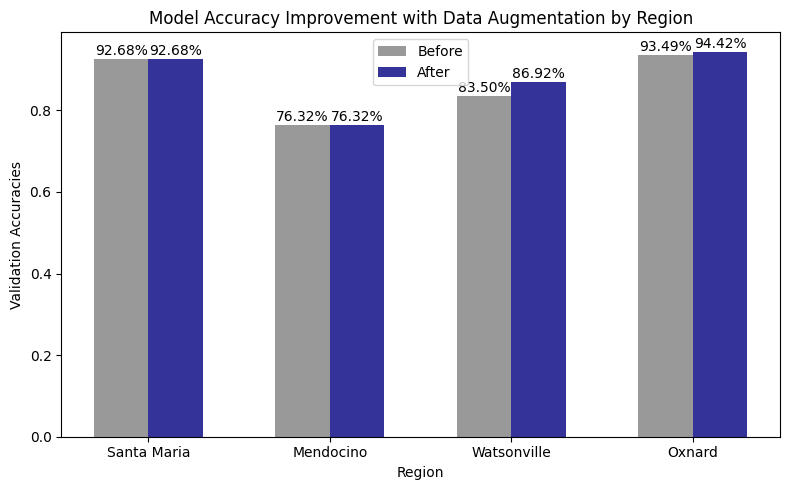

In [ ]:
# Set the width of the bars and the positions of the bars
bar_width = 0.3
index = np.arange(len(counties))

# Create the grouped bar chart
plt.figure(figsize=(8, 5))
bars1 = plt.bar(index, accuracy_before_augmentation, bar_width, label='Before', color='grey', alpha=0.8)
bars2 = plt.bar(index + bar_width, accuracy_after_augmentation, bar_width, label='After', color='navy', alpha=0.8)

# Add percentage values on top of the bars
for bar1, bar2 in zip(bars1, bars2):
    plt.text(bar1.get_x() + bar1.get_width() / 2, bar1.get_height() + 0.01, f'{bar1.get_height():.2%}', ha='center', color='black', fontsize=10)
    plt.text(bar2.get_x() + bar2.get_width() / 2, bar2.get_height() + 0.01, f'{bar2.get_height():.2%}', ha='center', color='black', fontsize=10)

# Add labels, titles, and legend
plt.xlabel('Region')
plt.ylabel('Validation Accuracies')
plt.title('Model Accuracy Improvement with Data Augmentation by Region')
plt.xticks(index + bar_width / 2, counties)
plt.legend()

# Display the chart
plt.tight_layout()
plt.show()

# Save Model

In [ ]:
def save_classifier(classifier, model_name, drive_folder):
  trees = ee.List(ee.Dictionary(classifier.explain()).get('trees'))
  dummy = ee.Feature(None)
  col = ee.FeatureCollection(trees.map(lambda x:  dummy.set('tree',x)))
  task = ee.batch.Export.table.toDrive(
    collection=col,
    description=model_name,
    folder=drive_folder
  )
  task.start()

In [ ]:
save_classifier(trained_RF, "trained_RF", 'tnc-models')
save_classifier(trained_RF_all, "trained_RF_augmented", 'tnc-models')

### Archive

In [ ]:
# spatial join that never worked out due to no anonymous fns in python
# # changing this to simply drop points within those regions
# points = ee.FeatureCollection.randomPoints(polygons.geometry(), 1000, 0);

# # spatial join polygon properties (i.e. class) to the random points
# spatialFilter = ee.Filter.intersects(**{
#   'leftField': '.geo',
#   'rightField': '.geo',
#   'maxError': 5
# })

# # Define a save all join
# saveAllJoin = ee.Join.saveAll(**{
#   'matchesKey': 'points',
# })

# # intersectJoined = saveAllJoin.apply(random_points, polygons, spatialFilter)

# intersectJoined = saveAllJoin.apply(**{
#     'primary': polygons,
#     'secondary': points,
#     'condition': spatialFilter
# })



# def transform(polygon):
#     label = polygon.get('class')
#     points = ee.FeatureCollection(ee.List(polygon.get('points'))).map(getpoint)
#     def getpoint(point, label):
#         return point.set('class', label)
#     return points.map(getpoint, label)

# # def transform(polygon):
# #     label = polygon.get('class')
# #     points = ee.FeatureCollection(ee.List(polygon.get('points'))).map(getpoint)
# #     return points.map(lambda point: point.set('class', label))


# points_w = intersectJoined.map(transform).flatten()